In [20]:
# Import packages
from pybaseball import statcast
import numpy as np
import movement
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

In [10]:
#start = '2017-05-01'
# Use shorter time period so I can load this into memory
start = '2019-09-20'
end = '2019-10-06'
data = statcast(start, end)

This is a large query, it may take a moment to complete
Completed sub-query from 2019-09-20 to 2019-09-25
Completed sub-query from 2019-09-26 to 2019-10-01
Completed sub-query from 2019-10-02 to 2019-10-06


In [3]:
# Iterate through columns_keep and use pop() to remove the columns from `column`
# We will the use data.drop([columns]) to remove the remaining columns from the data frame
def remove_columns(all_columns, remove):
    """
    Parameters
    ----------
    all_columns: list
        all columns in a Pandas dataframe
    remove: list
        columns to remove from 'all_columns'
    Returns
    -------
    all_columns: list
        Updated columns after removal
    """
    for col in remove:
        all_columns.remove(col)
    
    return all_columns


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [11]:
columns = list(data.columns)
columns_keep = ['pitch_type', 
                'release_speed',
                'release_pos_x',
                'release_pos_z',
                'pfx_x',
                'pfx_z',
                'plate_x',
                'plate_z',
                'zone',
                'vx0',
                'vy0',
                'vz0',
                'ax',
                'ay',
                'az',
                'release_spin_rate',
                'release_extension',
                'release_pos_y'
               ]

# Drop dolumns not in `columns_keep`
col_to_drop = remove_columns(columns, columns_keep)
data = data.drop(col_to_drop, axis=1)

In [12]:
# Add movement in x and z directions
v_o = [data.vx0, data.vy0, data.vz0]
p_o = [data.release_pos_x, data.release_pos_y, data.release_pos_z]
a = [data.ax, data.ay, data.az]
dx, dz, dzg = movement.calc_movement(p_o, v_o, a)
data['movement_x'] = dx
data['movement_z'] = dz

In [13]:
# Remove data points that have no pitch_type
#data = data.dropna(subset=['pitch_type'])
data = data.dropna()
pitch_types = list(data.pitch_type.values)

#Creating the dependent variable class
import pandas as pd
factor = pd.factorize(data['pitch_type'])
data['pitch_type'] = factor[0]
definitions = factor[1]
print(set(data.pitch_type))
print(definitions)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Index(['FC', 'KC', 'SL', 'CH', 'FF', 'FT', 'CU', 'SI', 'FS', 'EP'], dtype='object')


In [16]:
# Split the data into the features (X) and the label to predict (y)
y = data['pitch_type']
X = data.loc[:, data.columns != 'pitch_type']

#scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

# Now use `train_test_split` in scikit-learn to split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.35, random_state=0)

# Balance the data using imblearn
X_resampled, y_resampled = RandomOverSampler(sampling_strategy='not majority', random_state=69).fit_resample(X_train,y_train)

In [18]:
# Run Random Forest Model
rf = RandomForestClassifier(n_estimators=100,
                           oob_score=True,
                           random_state=0)

rf.fit(X_resampled, y_resampled)

rf_predictions = rf.predict(X_test)

#Reverse factorize (converting y_pred from 0s,1s and 2s
reversefactor = dict(zip(range(len(definitions)),definitions))
y_update = np.vectorize(reversefactor.get)(y_test)
rf_update = np.vectorize(reversefactor.get)(rf_predictions)
# Making the Confusion Matrix
print(pd.crosstab(y_update, rf_update, rownames=['Actual Pitches'], colnames=['Predicted Pitches']))

Predicted Pitches    CH    CU   FC    FF   FS    FT   KC   SI    SL
Actual Pitches                                                     
CH                 1629     5    6    10   13    44    0   14    11
CU                    2  1388    0     0    0     0   11    0   176
EP                    0     1    0     0    0     0    0    0     0
FC                    4     4  650    64    0     1    0    0   218
FF                   16     0   27  5402    0   139    0   50     6
FS                   70     0    0     0  131     0    0    4     7
FT                   30     0    0   139    0  1005    0  104     0
KC                    0   120    0     0    0     0  161    0    13
SI                   31     0    1    97    0   171    0  760     0
SL                   11   120   83     5    6     0    9    1  2467


Normalized confusion matrix


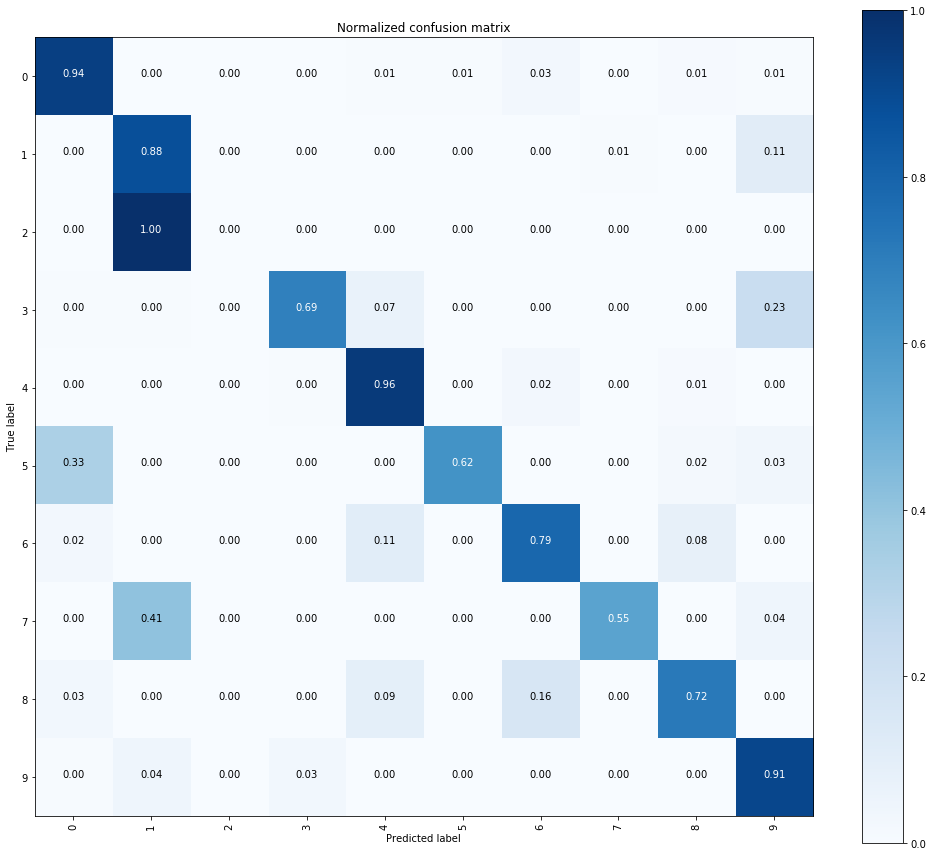

In [21]:
# Plot confusion matrix
cnf_matrix = confusion_matrix(y_update, rf_update)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=list(set(data.pitch_type)), normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
#TODO: ROC curve
https://github.com/javaidnabi31/Multi-class-with-imbalanced-dataset-classification/blob/master/20-news-group-classification.ipynb